# Fetch the data

In [1]:
import polars as pl
import numpy as np
# import requests
import pandas as pd

In [2]:
url = 'https://storage.googleapis.com/open-courses/dmeyf2023-8a1e/competencia_03_crudo.csv.gz'
r = requests.get(url, allow_redirects=True)

In [3]:
with open('dataset3.csv.gz', 'wb') as file:
    file.write(r.content)

In [4]:
!gunzip dataset3.csv.gz

In [2]:
%%time

df = pl.read_csv('dataset3.csv', infer_schema_length=10000)

CPU times: user 49.1 s, sys: 30.9 s, total: 1min 20s
Wall time: 2.39 s


# Data prep

In [3]:
min_val_dict = (
    df.select(
        pl.col(pl.Int64).min()
    )
).to_dict()
max_val_dict = (
    df.select(
        pl.col(pl.Int64).max()
    )
).to_dict()

bool_cols = []

uint8_cols = []
uint16_cols = []
uint32_cols = []
uint64_cols = []

int8_cols = []
int16_cols = []
int32_cols = []
int64_cols = []

for k in min_val_dict.keys():
    if min_val_dict[k][0]==0 and max_val_dict[k][0]==1:
        bool_cols.append(k)
    elif min_val_dict[k][0]>=0 and max_val_dict[k][0]<=255:
        uint8_cols.append(k)
    elif min_val_dict[k][0]>=0 and max_val_dict[k][0]<=65535:
        uint16_cols.append(k)
    elif min_val_dict[k][0]>=0 and max_val_dict[k][0]<=4294967295:
        uint32_cols.append(k)
    elif min_val_dict[k][0]>=0:
        uint64_cols.append(k)
    elif min_val_dict[k][0]>=-128 and max_val_dict[k][0]<=127:
        int8_cols.append(k)
    elif min_val_dict[k][0]>=-32768 and max_val_dict[k][0]<=32767:
        int16_cols.append(k)
    elif min_val_dict[k][0]>=-2147483648 and max_val_dict[k][0]<=2147483647:
        int32_cols.append(k)
    else:
        print(f'Int64? {k}, min={min_val_dict[k][0]}, max={max_val_dict[k][0]}')
        int64_cols.append(k)

In [4]:
all_int_cols = [bool_cols,
                uint8_cols,
                uint16_cols,
                uint32_cols,
                uint64_cols,
                int8_cols,
                int16_cols,
                int32_cols,
                int64_cols
               ]

[len(x) for x in all_int_cols]

[8, 44, 20, 2, 0, 0, 3, 2, 0]

In [5]:
df = df.with_columns(
    [
        pl.col(pl.Float64).cast(pl.Float32),
        pl.col(bool_cols).cast(pl.Boolean),
        pl.col(uint8_cols).cast(pl.UInt8),
        pl.col(uint16_cols).cast(pl.UInt16),
        pl.col(uint32_cols).cast(pl.UInt32),
        pl.col(uint64_cols).cast(pl.UInt64),
        pl.col(int8_cols).cast(pl.Int8),
        pl.col(int16_cols).cast(pl.Int16),
        pl.col(int32_cols).cast(pl.Int32),
        pl.col(int64_cols).cast(pl.Int64),
    ]
)
print(df.estimated_size())
# df.write_parquet('crude_dataset3.parquet')

2069493296


In [6]:
month_ranking = list(df.select(pl.col('foto_mes').unique())['foto_mes'])
month_ranking = {el:i for i, el in enumerate(month_ranking)}

In [7]:
x=(
    df
    .groupby("numero_de_cliente", maintain_order=True)
    .max()
    .select(
        [
            pl.col('numero_de_cliente'), 
            pl.col('foto_mes').alias('last_month')
        ]
    )
)
df = df.join(x, on="numero_de_cliente")

/tmp/ipykernel_2347398/1147081848.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  df


In [8]:
df = (
    df.select(
        [
            pl.all(),
            pl.col('foto_mes').apply(function=lambda x: month_ranking[x],return_dtype=pl.UInt8).alias('month_rk'),
            pl.col('last_month').apply(function=lambda x: month_ranking[x],return_dtype=pl.UInt8).alias('lm_rk')
        ]
    ).select(
        [pl.all(),
        (pl.col('lm_rk')-pl.col('month_rk')).alias('month_diff')]
    ).with_columns(
        pl.when(pl.col("foto_mes")==202109)
        .then('C')
        .when(pl.col("month_diff")==0)
        .then('B1') # target engineering uniting B1 and B2
        .when((pl.col("month_diff")==1) & (pl.col("foto_mes")!=202108))
        .then('B2')
        .otherwise('C')
        .alias("target")
    )
)

df = df.drop(['last_month','month_rk','lm_rk','month_diff'])

/tmp/ipykernel_2347398/892190521.py:5: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col('foto_mes').apply(function=lambda x: month_ranking[x],return_dtype=pl.UInt8).alias('month_rk'),
/tmp/ipykernel_2347398/892190521.py:5: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `map_elements` with the following:
  - pl.col("foto_mes").map_elements(lambda x: ...)
  + pl.col("foto_mes").map_dict(month_ranking)

  pl.col('foto_mes').apply(function=lambda x: month_ranking[x],return_dtype=pl.UInt8).alias('month_rk'),
/tmp/ipykernel_2347398/892190521.py:6: DeprecationWarning: `apply` is deprecated. It has been renamed to `map_elements`.
  pl.col('last_month').apply(function=lambda x: month_ranking[x],return_dtype=pl.UInt8).alias('lm_rk')
/tmp/ipykernel_2347398/892190521.py:6: PolarsInefficientMapWarning

In [9]:
df = df.with_columns(
    pl.when(pl.col(pl.Float32) != 0)
        .then(pl.col(pl.Float32)) # keep original value
        .keep_name()
)
float_cols = (
    df.select(
        pl.col(pl.Float32)
    )
).to_dict().keys()
float_cols = list(float_cols)

df = df.with_columns([
    pl.col(pl.Float32).shift(1).over("numero_de_cliente").suffix("_lag1"),
    pl.col(pl.Float32).shift(3).over("numero_de_cliente").suffix("_lag3"),
    pl.col(pl.Float32).shift(6).over("numero_de_cliente").suffix("_lag6"),
])

baseline = df.filter((pl.col('foto_mes')<=202107) & (pl.col('foto_mes')>=202010))
baseline.write_parquet('baseline_with_lags.parquet')

In [10]:
%%time
baseline = df.filter((pl.col('foto_mes')<=202107) & (pl.col('foto_mes')>=202010))
baseline.write_parquet('baseline_raw.parquet')

baseline = baseline.with_columns(
    pl.when(pl.col(pl.Float32) != 0)
        .then(pl.col(pl.Float32)) # keep original value
        .keep_name()
)
baseline.write_parquet('baseline_nulls.parquet')

CPU times: user 9.09 s, sys: 3.36 s, total: 12.4 s
Wall time: 6.15 s


In [11]:
df = df.with_columns(
    pl.when(pl.col(pl.Float32) != 0)
        .then(pl.col(pl.Float32)) # keep original value
        .keep_name()
)

/tmp/ipykernel_3672392/3497531217.py:2: DeprecationWarning: `keep_name` is deprecated. It has been moved to `name.keep`.
  pl.when(pl.col(pl.Float32) != 0)


In [12]:
float_cols = (
    df.select(
        pl.col(pl.Float32)
    )
).to_dict().keys()
float_cols = list(float_cols)

In [13]:
%%time

df = df.with_columns([
    pl.col(pl.Float32).shift(1).over("numero_de_cliente").suffix("_lag1"),
    pl.col(pl.Float32).shift(2).over("numero_de_cliente").suffix("_lag2"),
    pl.col(pl.Float32).shift(3).over("numero_de_cliente").suffix("_lag3"),
    pl.col(pl.Float32).shift(6).over("numero_de_cliente").suffix("_lag6"),
])

<timed exec>:2: DeprecationWarning: `suffix` is deprecated. It has been moved to `name.suffix`.
<timed exec>:3: DeprecationWarning: `suffix` is deprecated. It has been moved to `name.suffix`.
<timed exec>:4: DeprecationWarning: `suffix` is deprecated. It has been moved to `name.suffix`.
<timed exec>:5: DeprecationWarning: `suffix` is deprecated. It has been moved to `name.suffix`.


CPU times: user 3min 7s, sys: 24.8 s, total: 3min 32s
Wall time: 2min 15s


In [14]:
df.write_parquet('data_prepared.parquet')

# Autogluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
from autogluon.core.metrics import make_scorer


df = pd.read_parquet('data_prepared.parquet')
df = df.drop(columns=['numero_de_cliente'])
df['foto_mes'] = pd.to_datetime(df['foto_mes'], format='%Y%m')
df['target'] = df['target'].map({'C': 0, 'B2': 1})
df_test = df[df['foto_mes']=='2021-09-01']
df_train = df[df['foto_mes']<='2021-07-01']
train_data = TabularDataset(df_train)
test_data = TabularDataset(df_test)


def normalized_ganancia(y_true: np.array,
                      y_pred: np.array) -> float:
    ideal_value = np.sum(y_true)*0.273
    ganancia = y_true*0.280 - 0.007
    ganancia_df = pd.DataFrame({'prob': y_pred, 'ganancia': ganancia})
    ganancia_df = ganancia_df.sort_values(by='prob', ascending=False).reset_index(drop=True)
    ganancia_df['ganancia_roll'] = ganancia_df['ganancia'].cumsum()
    
    gan_max = ganancia_df['ganancia_roll'].max()
    ind = ganancia_df[ganancia_df['ganancia_roll']==gan_max].index[0]
    lo = ind-2000 if ind>2000 else 0
    res = np.mean(ganancia_df['ganancia_roll'].iloc[lo:ind])
    
    normalized_res = res/ideal_value
    print(f'ideal_value {ideal_value} res {res}, ind {ind}, gan_max {gan_max} normalized_res {normalized_res}')
    return normalized_res

ag_ganancia_custom_scorer = make_scorer(name='normalized_ganancia',
                                      score_func=normalized_ganancia,
                                      optimum=1,
                                      greater_is_better=True)

#the best scorer actually used the default metric, not the custom
predictor = TabularPredictor(label='target').fit(
    train_data,
    time_limit = 8*3600,
    num_cpus = 36,
    excluded_model_types = ['KNN', 'XT' ,'RF'], #to avoid OOM errors
    presets = 'best_quality',
)

df_sub = pd.read_parquet('data_prepared.parquet')
df_sub['foto_mes'] = pd.to_datetime(df_sub['foto_mes'], format='%Y%m')
df_test = df_sub[df_sub['foto_mes']=='2021-09-01']
probs = predictor.predict_proba(df_test.drop(columns=['numero_de_cliente']))
ans = df_test[['numero_de_cliente']].join(probs)
ans = ans.sort_values(by=1, ascending=False)
ans = ans.reset_index(drop=True)
num_clientes = 10500
k = num_clientes/1000
thr = ans.iloc[num_clientes][1]
ans['Predicted'] = np.where(ans[1]>=thr, 1, 0)
ans[['numero_de_cliente', 'Predicted']].to_csv(f'autogluon_sub_{k}k.csv', index=False)

# The rest of the code is just some of the experiments on models, ensembling and tuning

# Tune xgboost

In [2]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from numpy import argmax
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [5]:
df = pd.read_parquet('data_prepared.parquet')
df = df.drop(columns=['numero_de_cliente'])
df['target'] = df['target'].map({'C': 0, 'B2': 1})
df_test = df[df['foto_mes']==202107]
df_train = df[df['foto_mes']<202107]

In [7]:
df_train = df_train[df_train['foto_mes']>=202101]

In [4]:
def ganancia_integral(probs: np.array, 
                      y_true: np.array) -> float:
    ganancia_df = pd.DataFrame({'prob': probs, 'truth': y_true})
    ganancia_df = ganancia_df.sort_values(by='prob', ascending=False).reset_index(drop=True)
    ganancia_df['ganancia_ind'] = np.where(ganancia_df['truth']==1, 273, -7)
    ganancia_df['ganancia_roll'] = ganancia_df['ganancia_ind'].cumsum()
    gan_max = ganancia_df['ganancia_roll'].max()
    ind = ganancia_df[ganancia_df['ganancia_roll']==gan_max].index[0]
    res = np.mean(ganancia_df['ganancia_roll'].iloc[ind-1000:ind+1001])
    return res

In [8]:
X_train = df_train.drop(columns=['foto_mes', 'target']).to_numpy()
X_val = df_test.drop(columns=['foto_mes', 'target']).to_numpy()
y_train = df_train['target'].to_numpy()
y_val = df_test['target'].to_numpy()

In [3]:
from typing import Literal, Optional, List
import random
from concurrent.futures import ThreadPoolExecutor


Classifiers = Literal['xgb', 'lgbm', 'catboost']
Strategy = Literal['avg', 'linreg']

class GBDTEnsemble():

    def __init__(self,
                 seeds: List[int],
                 clf_kwargs: dict,
                 base_clf: Classifiers='xgb',
                 ensemble_strategy: Strategy='avg'):
        self.n_estimators = len(seeds)
        if base_clf=='xgb':
            self.estimators = [XGBClassifier(random_state=s, **clf_kwargs, n_jobs=24) for s in seeds]
        elif base_clf=='lgbm':
            self.estimators = [LGBMClassifier(random_state=s, **clf_kwargs) for s in seeds]
        elif base_clf=='catboost':
            self.estimators = [CatBoostClassifier(random_state=s, **clf_kwargs) for s in seeds]
        else:
            raise ValueError('Only valid base classifiers are xgb, lgbm, and catboost')
        self.ensemble_strategy = ensemble_strategy

    def fit(self, X_train, y_train) -> None:
        # with ThreadPoolExecutor() as executor:
        #     futures = [executor.submit(clf.fit, X_train, y_train) for clf in self.estimators]
        #     for future in futures:
        #         future.result()
        for i, clf in enumerate(self.estimators):
            print(f'Start {i}')
            clf.fit(X_train, y_train, verbose=True)

    def predict_proba(self, X_val) -> np.array:
        if self.ensemble_strategy=='avg':
            initial_probs = np.zeros(X_val.shape[0])
            for clf in self.estimators:
                probs = clf.predict_proba(X_val)[:,1]
                initial_probs += probs
            return initial_probs/self.n_estimators
        else:
            raise NotImplementedError('Need to change the API to support more advanced stacking')

In [16]:
%%time

#XGBoost tuning

space={
    'max_depth': hp.quniform("max_depth", 2, 6, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'scale_pos_weight': hp.quniform("scale_pos_weight", 5, 25, 1),
}

def objective(space):
    hyperparams = {
        'eval_metric': "aucpr",
        'n_estimators': 15, 
        'max_depth': int(space['max_depth']), 
        'gamma': space['gamma'],
        'reg_alpha': int(space['reg_alpha']),
        'min_child_weight': int(space['min_child_weight']),
        'colsample_bytree': 0.68,
        'scale_pos_weight': int(space['scale_pos_weight']),
        'learning_rate': 1.0,
    }
    random.seed(311111) 
    seeds = [random.randint(1, 1000000) for i in range(5)]
    clf = GBDTEnsemble(
        seeds=seeds,
        clf_kwargs=hyperparams,
        base_clf='xgb',
        ensemble_strategy='avg'
    )
    clf.fit(X_train, y_train)
    
    preds = clf.predict_proba(X_val)
    print('ensemble done')
    precision, recall, thresholds = metrics.precision_recall_curve(y_val, preds, pos_label=1)
    beta = 2
    fbeta = ((1+beta**2) * precision * recall) / ((beta**2) * precision + recall+0.000001)
    ix = argmax(fbeta)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fbeta[ix]}, recall={recall[ix]}, precision={precision[ix]}')
    return {'loss': -fbeta[ix], 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 75,
                        trials = trials)
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

Start 0                                                                                                                 
Start 1                                                                                                                 
Start 2                                                                                                                 
Start 3                                                                                                                 
Start 4                                                                                                                 
ensemble done                                                                                                           
Best Threshold=0.2964788392186165, F-Score=0.40720786396531844, recall=0.6456289978678038, precision=0.16438653637350706
Start 0                                                                                                                 
Start 1                         

In [4]:
%%time

df = pl.read_parquet('data_prepared.parquet')

X = df.select(pl.all().exclude('target'))
y = df.select([pl.col('target'), pl.col('foto_mes')])

X_test = X.filter(pl.col('foto_mes')==202109)
X_train = X.filter(pl.col('foto_mes')<=202107)

X_test = X_test.select(pl.all().exclude(['foto_mes', 'numero_de_cliente'])).to_numpy()
X_train = X_train.select(pl.all().exclude(['foto_mes', 'numero_de_cliente'])).to_numpy()

y_train = y.filter(pl.col('foto_mes')<=202107)
y_train = y_train.select(pl.all().exclude('foto_mes')).to_numpy()
y_train = y_train.reshape(y_train.shape[0])
y_train = np.where(y_train=='B2', 1, 0)

CPU times: user 1min 6s, sys: 1min 41s, total: 2min 47s
Wall time: 1min 26s


In [ ]:
params = {
    'colsample_bytree': 0.68, 
    'gamma': 5.431244251167458, 
    'learning_rate': 1.0, 
    'max_depth': 6, 
    'min_child_weight': 10.0, 
    'n_estimators': 15, 
    'reg_alpha': 51.0, 
    'reg_lambda': 0.7207767882698669, 
    'scale_pos_weight': 21.0,
    'eval_metric': "aucpr",
}
random.seed(158151) 
seeds = [random.randint(1, 1000000) for i in range(33)]
clf = GBDTEnsemble(
    seeds=seeds,
    clf_kwargs=params,
    base_clf='xgb',
    ensemble_strategy='avg'
)
clf.fit(X_train, y_train)

probs = clf.predict_proba(X_test)

In [7]:
df_sub = pd.read_parquet('data_prepared.parquet')
df_sub = df_sub[df_sub['foto_mes']==202109]

ans = df_sub[['numero_de_cliente']]
ans['probs'] = probs

/tmp/ipykernel_1220584/566418379.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans['probs'] = probs


In [20]:
ans = ans.sort_values(by='probs', ascending=False)
ans = ans.reset_index(drop=True)
num_clientes = 12000
k = num_clientes/1000
thr = ans.iloc[num_clientes][1]
ans['Predicted'] = np.where(ans['probs']>=thr, 1, 0)
ans[['numero_de_cliente', 'Predicted']].to_csv(f'xgb_ensemble_{k}k.csv', index=False)

In [16]:
%%time

params = {'colsample_bytree': 0.8234117866932102, 
          'gamma': 3.411738486797951, 
          'learning_rate': 0.07585808547362471, 
          'max_depth': 12, 
          'min_child_weight': 3.0, 
          'n_estimators': 150, 
          'reg_alpha': 89.0, 
          'reg_lambda': 0.7207767882698669, 
          'scale_pos_weight': 2.0
         }
xgb2 = XGBClassifier(**params)
xgb2.fit(X_train, y_train)

probs2 = xgb2.predict_proba(X_test)
probs2 = probs2[:,1]

CPU times: user 10h 8min 39s, sys: 18min 57s, total: 10h 27min 36s
Wall time: 16min 43s


In [20]:
ans['probs'] = (ans['probs']+probs2)/2

/tmp/ipykernel_9069/1647257964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ans['probs'] = (ans['probs']+probs2)/2


In [21]:
ans

,numero_de_cliente,probs
4727791,29183981,0.001197
4727792,29184630,0.001533
4727793,29185433,0.013432
4727794,29185587,0.001590
4727795,29185646,0.000388
...,...,...
4893023,188116410,0.003184
4893024,188117144,0.041174
4893025,188119945,0.040291
4893026,188127016,0.031221


In [29]:
ans = ans.sort_values(by='probs', ascending=False)
ans = ans.reset_index(drop=True)
num_clientes = 15000
k = num_clientes/1000
thr = ans.iloc[num_clientes][1]
ans['Predicted'] = np.where(ans['probs']>=thr, 1, 0)
ans[['numero_de_cliente', 'Predicted']].to_csv(f'xgb_ensemble{k}k.csv', index=False)

In [30]:
X_viz = X.filter(pl.col('foto_mes')==202107)
X_viz = X_viz.select(pl.all().exclude(['foto_mes', 'numero_de_cliente'])).to_numpy()

y_viz = y.filter(pl.col('foto_mes')==202107)
y_viz = y_viz.select(pl.all().exclude('foto_mes')).to_numpy()

y_viz = y_viz.reshape(y_viz.shape[0])
y_viz = np.where(y_viz=='B2', 1, 0)

In [31]:
probs = xgb.predict_proba(X_viz)

In [37]:
y_viz.shape, probs.shape

((164682,), (164682, 2))

In [38]:
ganancia_df = pd.DataFrame({'prob': probs[:,1], 'truth': y_viz})
ganancia_df = ganancia_df.sort_values(by='prob', ascending=False).reset_index(drop=True)
ganancia_df['ganancia_ind'] = np.where(ganancia_df['truth']==1, 273, -7)
ganancia_df['ganancia_roll'] = ganancia_df['ganancia_ind'].cumsum()

In [46]:
ganancia_plot = ganancia_df['ganancia_roll'].iloc[:40000].values

In [44]:
from matplotlib import pyplot as plt

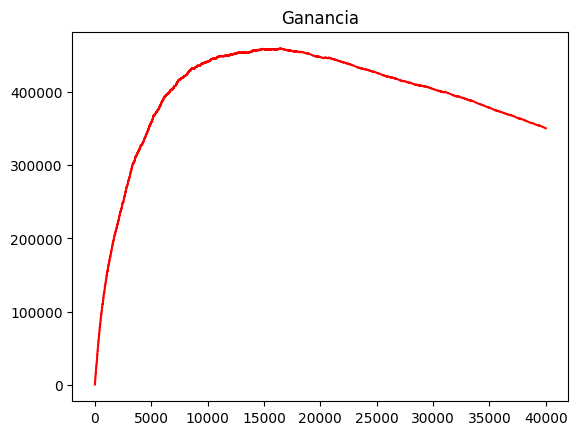

In [50]:
plt.plot(ganancia_plot, color='red')
plt.title('Ganancia')
plt.show()

In [56]:
help(plot_importance)

Help on function plot_importance in module xgboost.plotting:

plot_importance(booster: xgboost.core.Booster, ax: Optional[Any] = None, height: float = 0.2, xlim: Optional[tuple] = None, ylim: Optional[tuple] = None, title: str = 'Feature importance', xlabel: str = 'F score', ylabel: str = 'Features', fmap: Union[str, os.PathLike] = '', importance_type: str = 'weight', max_num_features: Optional[int] = None, grid: bool = True, show_values: bool = True, **kwargs: Any) -> Any
    Plot importance based on fitted trees.
    
    Parameters
    ----------
    booster : Booster, XGBModel or dict
        Booster or XGBModel instance, or dict taken by Booster.get_fscore()
    ax : matplotlib Axes, default None
        Target axes instance. If None, new figure and axes will be created.
    grid : bool, Turn the axes grids on or off.  Default is True (On).
    importance_type : str, default "weight"
        How the importance is calculated: either "weight", "gain", or "cover"
    
        * "weig

In [61]:
cols = list(df_train.drop(columns=['foto_mes', 'target']).columns)

<BarContainer object of 10 artists>

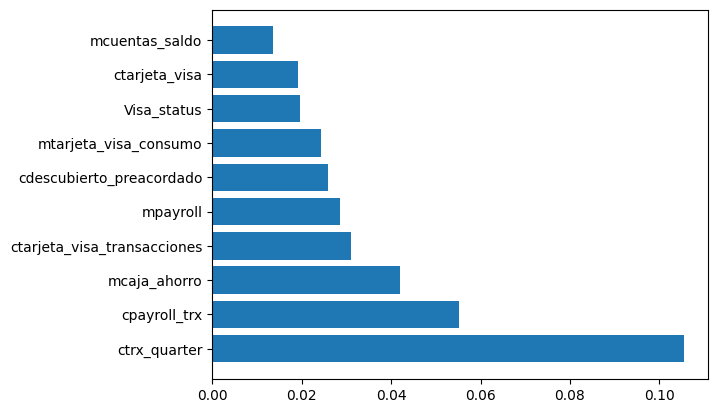

In [65]:
n_top_features = 10
sorted_idx = xgb.feature_importances_.argsort()[::-1]
plt.barh(df_train.drop(columns=['foto_mes', 'target']).columns[sorted_idx][:n_top_features ], 
                       xgb.feature_importances_[sorted_idx][:n_top_features ])

<BarContainer object of 444 artists>

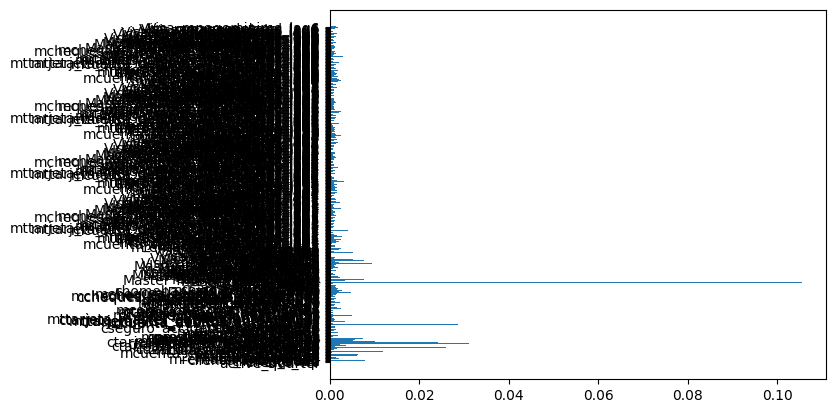

In [62]:
plt.barh(cols, xgb.feature_importances_)

In [63]:
help(plot_importance)

Help on function plot_importance in module xgboost.plotting:

plot_importance(booster: xgboost.core.Booster, ax: Optional[Any] = None, height: float = 0.2, xlim: Optional[tuple] = None, ylim: Optional[tuple] = None, title: str = 'Feature importance', xlabel: str = 'F score', ylabel: str = 'Features', fmap: Union[str, os.PathLike] = '', importance_type: str = 'weight', max_num_features: Optional[int] = None, grid: bool = True, show_values: bool = True, **kwargs: Any) -> Any
    Plot importance based on fitted trees.
    
    Parameters
    ----------
    booster : Booster, XGBModel or dict
        Booster or XGBModel instance, or dict taken by Booster.get_fscore()
    ax : matplotlib Axes, default None
        Target axes instance. If None, new figure and axes will be created.
    grid : bool, Turn the axes grids on or off.  Default is True (On).
    importance_type : str, default "weight"
        How the importance is calculated: either "weight", "gain", or "cover"
    
        * "weig

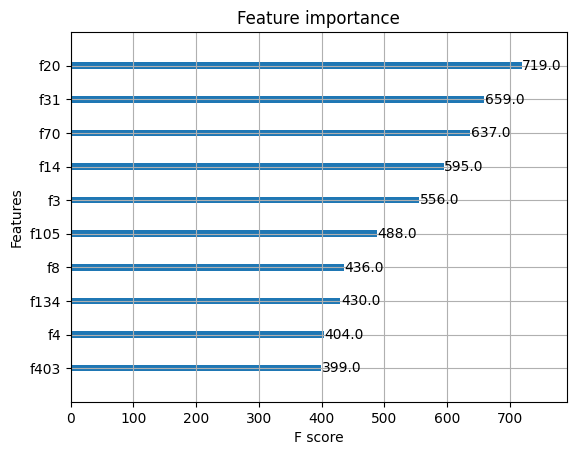

In [57]:
from xgboost import plot_importance

plot_importance(xgb, max_num_features=10)
plt.show()

In [ ]:
def ganancia_integral(probs: np.array, 
                      y_true: np.array) -> float:
    ganancia_df = pd.DataFrame({'prob': probs, 'truth': y_true})
    ganancia_df = ganancia_df.sort_values(by='prob', ascending=False).reset_index(drop=True)
    ganancia_df['ganancia_ind'] = np.where(ganancia_df['truth']==1, 273, -7)
    ganancia_df['ganancia_roll'] = ganancia_df['ganancia_ind'].cumsum()
    gan_max = ganancia_df['ganancia_roll'].max()
    ind = ganancia_df[ganancia_df['ganancia_roll']==gan_max].index[0]
    res = np.mean(ganancia_df['ganancia_roll'].iloc[ind-1000:ind+1001])
    return res

In [ ]:
df_sub = pd.read_parquet('data_prepared.parquet')
df_sub = df_sub[df_sub['foto_mes']==202107]

ans = df_sub[['numero_de_cliente']]
ans['probs'] = probs

# Autogluon

In [20]:
predictor = TabularPredictor(label='target').fit(
    train_data,
    time_limit = 6*3600,
    num_cpus = 36,
    excluded_model_types = ['KNN', 'XT' ,'RF'],
    presets = 'best_quality',
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231122_221728/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 21600s
AutoGluon will save models to "AutogluonModels/ag-20231122_221728/"
AutoGluon Version:  0.8.2
Python Version:     3.9.7
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #85-Ubuntu SMP Fri Jul 7 15:25:09 UTC 2023
Disk Space Avail:   363.25 GB / 982.70 GB (37.0%)
Train Data Rows:    4562810
Train Data Columns: 445
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> 

In [8]:
predictor = TabularPredictor.load("AutogluonModels/ag-20231122_221728/")

In [9]:
df_sub = pd.read_parquet('data_prepared.parquet')
df_sub['foto_mes'] = pd.to_datetime(df_sub['foto_mes'], format='%Y%m')
df_test = df_sub[df_sub['foto_mes']=='2021-09-01']

In [10]:
probs = predictor.predict_proba(df_test.drop(columns=['numero_de_cliente']))
ans = df_test[['numero_de_cliente']].join(probs)
ans = ans.sort_values(by=1, ascending=False)
ans = ans.reset_index(drop=True)

In [17]:
num_clientes = 9500
k = num_clientes/1000
thr = ans.iloc[num_clientes][1]
ans['Predicted'] = np.where(ans[1]>=thr, 1, 0)
ans[['numero_de_cliente', 'Predicted']].to_csv(f'autogluon_sub_best_preset_{k}k.csv', index=False)

In [10]:
predictor = TabularPredictor(label='target', eval_metric='f1').fit(
    train_data,
    time_limit = 6*3600,
    num_cpus = 36,
    excluded_model_types = ['KNN', 'XT' ,'RF'],
    presets = 'best_quality',
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231125_104752/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 21600s
AutoGluon will save models to "AutogluonModels/ag-20231125_104752/"
AutoGluon Version:  0.8.2
Python Version:     3.9.7
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #85-Ubuntu SMP Fri Jul 7 15:25:09 UTC 2023
Disk Space Avail:   345.73 GB / 982.70 GB (35.2%)
Train Data Rows:    4562810
Train Data Columns: 445
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> 

In [9]:
predictor = TabularPredictor(label='target', eval_metric=ag_ganancia_custom_scorer).fit(
    train_data,
    time_limit = 6*3600,
    num_cpus = 36,
    excluded_model_types = ['KNN', 'XT' ,'RF'],
    presets = 'best_quality',
)

No path specified. Models will be saved in: "AutogluonModels/ag-20231125_173748/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 21600s
AutoGluon will save models to "AutogluonModels/ag-20231125_173748/"
AutoGluon Version:  0.8.2
Python Version:     3.9.7
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #85-Ubuntu SMP Fri Jul 7 15:25:09 UTC 2023
Disk Space Avail:   338.09 GB / 982.70 GB (34.4%)
Train Data Rows:    4562810
Train Data Columns: 445
Label Column: target
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> 

ideal_value 1419.873 res nan, ind 0, gan_max -0.007000000216066837 normalized_res nan
ideal_value 1419.873 res nan, ind 0, gan_max -0.007000000216066837 normalized_res nan
ideal_value 1419.873 res nan, ind 0, gan_max -0.007000000216066837 normalized_res nan
ideal_value 1419.873 res nan, ind 0, gan_max -0.007000000216066837 normalized_res nan
ideal_value 1419.873 res 0.44216665625572205, ind 6, gan_max 1.0709999799728394 normalized_res 0.00031141282090420904
ideal_value 1419.873 res 1.5155000686645508, ind 16, gan_max 3.241000175476074 normalized_res 0.0010673490295713425
ideal_value 1419.873 res 4.031281471252441, ind 39, gan_max 7.839997291564941 normalized_res 0.0028391845406261274
ideal_value 1419.873 res 17.662755966186523, ind 160, gan_max 33.5930290222168 normalized_res 0.012439673101880606
ideal_value 1419.873 res 29.322586059570312, ind 277, gan_max 57.41392135620117 normalized_res 0.020651555497970812
ideal_value 1419.873 res 35.669097900390625, ind 338, gan_max 68.18688964843

	0.009	 = Validation score   (normalized_ganancia)
	867.47s	 = Training   runtime
	54.57s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 20267.5s of the 20267.5s of remaining time.


ideal_value 11357.619 res 102.3027974588929, ind 1338, gan_max 200.90699999999651 normalized_res 0.009007415855285592


	Memory not enough to fit LGBModel folds in parallel. Will do sequential fitting instead. 	Consider decreasing folds trained in parallel by passing num_folds_parallel to ag_args_ensemble when calling predictor.fit
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


ideal_value 1419.873 res nan, ind 0, gan_max -0.007000000216066837 normalized_res nan
ideal_value 1419.873 res nan, ind 0, gan_max -0.007000000216066837 normalized_res nan
ideal_value 1419.873 res nan, ind 0, gan_max 0.27300000190734863 normalized_res nan
ideal_value 1419.873 res 0.12950000166893005, ind 2, gan_max 0.5390000343322754 normalized_res 9.120534137132691e-05
ideal_value 1419.873 res 13.014166831970215, ind 120, gan_max 26.87302017211914 normalized_res 0.009165725971245467
ideal_value 1419.873 res 17.028976440429688, ind 155, gan_max 34.468021392822266 normalized_res 0.011993309570947321
ideal_value 1419.873 res 19.597393035888672, ind 174, gan_max 38.2550048828125 normalized_res 0.013802215434682307
ideal_value 1419.873 res 29.2222900390625, ind 267, gan_max 56.92392349243164 normalized_res 0.020580918180050256
ideal_value 1419.873 res 31.24170684814453, ind 293, gan_max 62.62190246582031 normalized_res 0.02200316989487407
ideal_value 1419.873 res 39.60029602050781, ind 381

	0.0083	 = Validation score   (normalized_ganancia)
	815.4s	 = Training   runtime
	53.14s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 19270.13s of the 19270.13s of remaining time.


ideal_value 11357.619 res 93.72055088309428, ind 1189, gan_max 191.58999999999713 normalized_res 0.008251778025226439


	Memory not enough to fit CatBoostModel folds in parallel. Will do sequential fitting instead. 	Consider decreasing folds trained in parallel by passing num_folds_parallel to ag_args_ensemble when calling predictor.fit
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1691.


ideal_value 1419.873 res 105.26066312056662, ind 1128, gan_max 214.97699999999722 normalized_res 0.0741338578313459


	Ran out of time, early stopping on iteration 1900.


ideal_value 1419.873 res 114.40328769356051, ind 1227, gan_max 217.64399999999665 normalized_res 0.08057290172681678


	Ran out of time, early stopping on iteration 1919.


ideal_value 1419.6000000000001 res 114.23057508532324, ind 1172, gan_max 224.18899999999678 normalized_res 0.08046673364702961


	Ran out of time, early stopping on iteration 1994.


ideal_value 1419.6000000000001 res 115.78011074104806, ind 1201, gan_max 230.4259999999967 normalized_res 0.08155826341296707


	Ran out of time, early stopping on iteration 2140.


ideal_value 1419.6000000000001 res 113.79880821917712, ind 1168, gan_max 224.49699999999686 normalized_res 0.08016258679851868


	Ran out of time, early stopping on iteration 2154.


ideal_value 1419.6000000000001 res 109.31972512234816, ind 1226, gan_max 216.25099999999676 normalized_res 0.07700741414648363


	Ran out of time, early stopping on iteration 2458.


ideal_value 1419.6000000000001 res 117.07427777777673, ind 1260, gan_max 228.33299999999662 normalized_res 0.08246990545067394


	Ran out of time, early stopping on iteration 3013.


ideal_value 1419.873 res 118.18867027477, ind 1201, gan_max 236.30599999999674 normalized_res 0.08323890254605165


	0.142	 = Validation score   (normalized_ganancia)
	18439.68s	 = Training   runtime
	29.04s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L1 ... Training model for up to 672.44s of the 672.44s of remaining time.


ideal_value 11357.619 res 1613.1989999998518, ind 9507, gan_max 1792.6439999997717 normalized_res 0.142036724422597


	Memory not enough to fit NNFastAiTabularModel folds in parallel. Will do sequential fitting instead. 	Consider decreasing folds trained in parallel by passing num_folds_parallel to ag_args_ensemble when calling predictor.fit
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
Metric normalized_ganancia is not supported by this model - using log_loss instead
	Time limit exceeded... Skipping NeuralNetFastAI_BAG_L1.
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 2133.02s of the -397.37s of remaining time.


ideal_value 11357.619 res 102.3027974588929, ind 1338, gan_max 200.90699999999651 normalized_res 0.009007415855285592
ideal_value 11357.619 res 93.72055088309428, ind 1189, gan_max 191.58999999999713 normalized_res 0.008251778025226439
ideal_value 11357.619 res 1613.1989999998518, ind 9507, gan_max 1792.6439999997717 normalized_res 0.142036724422597
ideal_value 11357.619 res 526.9710600000236, ind 3445, gan_max 738.3180000000513 normalized_res 0.04639802233197148
ideal_value 11357.619 res 586.663560000031, ind 3719, gan_max 796.6000000000605 normalized_res 0.051653745384488685
ideal_value 11357.619 res 1613.1989999998518, ind 9507, gan_max 1792.6439999997717 normalized_res 0.142036724422597
ideal_value 11357.619 res 961.5376400000683, ind 5573, gan_max 1170.0220000000331 normalized_res 0.08466014223580386
ideal_value 11357.619 res 968.6664400000711, ind 5655, gan_max 1181.2080000000335 normalized_res 0.08528780900293197
ideal_value 11357.619 res 1613.1989999998518, ind 9507, gan_max 17

	0.142	 = Validation score   (normalized_ganancia)
	422.51s	 = Training   runtime
	6.95s	 = Validation runtime
AutoGluon training complete, total runtime = 22438.16s ... Best model: "WeightedEnsemble_L2"


ideal_value 11357.619 res 1613.1989999998518, ind 9507, gan_max 1792.6439999997717 normalized_res 0.142036724422597


TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231125_173748/")


In [11]:
df_sub = pd.read_parquet('data_prepared.parquet')
df_sub['foto_mes'] = pd.to_datetime(df_sub['foto_mes'], format='%Y%m')
df_test = df_sub[df_sub['foto_mes']=='2021-09-01']

In [12]:
probs1 = predictor.predict_proba(df_test.drop(columns=['numero_de_cliente']))
predictor2 = TabularPredictor.load("AutogluonModels/ag-20231125_104752/")
probs2 = predictor2.predict_proba(df_test.drop(columns=['numero_de_cliente']))
predictor3 = TabularPredictor.load("AutogluonModels/ag-20231122_221728/")
probs3 = predictor3.predict_proba(df_test.drop(columns=['numero_de_cliente']))
predictor4 = TabularPredictor.load("AutogluonModels/ag-20231120_232226/")
probs4 = predictor4.predict_proba(df_test.drop(columns=['numero_de_cliente']))

In [14]:
ensemble_probs = probs1+probs2+probs3+probs4
ensemble_probs = ensemble_probs/4

In [16]:
ans = df_test[['numero_de_cliente']].join(ensemble_probs)
ans = ans.sort_values(by=1, ascending=False)
ans = ans.reset_index(drop=True)

In [ ]:
ans = df_test[['numero_de_cliente']].join(ensemble_probs)
ans = ans.sort_values(by=1, ascending=False)
ans = ans.reset_index(drop=True)
num_clientes = 11500
k = num_clientes/1000
thr = ans.iloc[num_clientes][1]
ans['Predicted'] = np.where(ans[1]>=thr, 1, 0)
ans[['numero_de_cliente', 'Predicted']].to_csv(f'autogluon_sub_best_preset_{k}k.csv', index=False)

In [28]:
num_clientes = 11500
k = num_clientes/1000
thr = ans.iloc[num_clientes][1]
ans['Predicted'] = np.where(ans[1]>=thr, 1, 0)
ans[['numero_de_cliente', 'Predicted']].to_csv(f'autogluon_sub_best_preset_{k}k.csv', index=False)

In [9]:
%%time
df = pl.read_parquet('data_prepared.parquet')

CPU times: user 26.6 s, sys: 38.4 s, total: 1min 5s
Wall time: 27.8 s


In [10]:
%%time

df = pl.read_parquet('data_prepared.parquet')

X = df.select(pl.all().exclude('target'))
y = df.select([pl.col('target'), pl.col('foto_mes')])

X_test = X.filter(pl.col('foto_mes')==202107)
X_train = X.filter((pl.col('foto_mes')<=202106) & (pl.col('foto_mes')>=202001))

X_test = X_test.select(pl.all().exclude(['foto_mes', 'numero_de_cliente'])).to_numpy()
X_train = X_train.select(pl.all().exclude(['foto_mes', 'numero_de_cliente'])).to_numpy()

y_train = y.filter((pl.col('foto_mes')<=202106) & (pl.col('foto_mes')>=202001))
y_train = y_train.select(pl.all().exclude('foto_mes')).to_numpy()

y_train = y_train.reshape(y_train.shape[0])
y_train = np.where(y_train=='B2', 1, 0)

y_test = y.filter(pl.col('foto_mes')==202107)
y_test = y_test.select(pl.all().exclude('foto_mes')).to_numpy()

y_test = y_test.reshape(y_test.shape[0])
y_test = np.where(y_test=='B2', 1, 0)

CPU times: user 22.9 s, sys: 48.8 s, total: 1min 11s
Wall time: 50.6 s


In [46]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from numpy import argmax
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
%%time

params = {'colsample_bytree': 0.7641758545981301, 
           'gamma': 6.424128698676173, 
           'max_depth': 5, 
           'min_child_weight': 0.0, 
           'n_estimators': 1024, 
           'reg_alpha': 86.0, 
           'reg_lambda': 0.48714545997765757, 
           'scale_pos_weight': 10}


xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)

probs = xgb.predict_proba(X_test)
probs = probs[:,1]

In [83]:
def ganancia_integral(probs: np.array, 
                      y_true: np.array) -> float:
    ganancia_df = pd.DataFrame({'prob': probs, 'truth': y_true})
    ganancia_df = ganancia_df.sort_values(by='prob', ascending=False).reset_index(drop=True)
    ganancia_df['ganancia_ind'] = np.where(ganancia_df['truth']==1, 273, -7)
    ganancia_df['ganancia_roll'] = ganancia_df['ganancia_ind'].cumsum()
    gan_max = ganancia_df['ganancia_roll'].max()
    ind = ganancia_df[ganancia_df['ganancia_roll']==gan_max].index[0]
    res = np.mean(ganancia_df['ganancia_roll'].iloc[ind-1000:ind+1001])
    return res

In [41]:
%%timeit

ganancia_integral(probs, y_test)

15.1 ms ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [93]:
from typing import Literal, Optional, List


Classifiers = Literal['xgb', 'lgbm', 'catboost']
Strategy = Literal['avg', 'linreg']

class GBDTEnsemble():

    def __init__(self,
                 seeds: List[int],
                 clf_kwargs: dict,
                 base_clf: Classifiers='xgb',
                 ensemble_strategy: Strategy='avg'):
        self.n_estimators = len(seeds)
        if base_clf=='xgb':
            self.estimators = [XGBClassifier(random_state=s, **clf_kwargs) for s in seeds]
        elif base_clf=='lgbm':
            self.estimators = [LGBMClassifier(random_state=s, **clf_kwargs) for s in seeds]
        elif base_clf=='catboost':
            self.estimators = [CatBoostClassifier(random_state=s, **clf_kwargs) for s in seeds]
        else:
            raise ValueError('Only valid base classifiers are xgb, lgbm, and catboost')
        self.ensemble_strategy = ensemble_strategy

    def fit(self, evaluation:tuple) -> None:
        for i, clf in enumerate(self.estimators):
            print(f'Start training classifier {i}')
            X_train = evaluation[0][0]
            y_train = evaluation[0][1]
            clf.fit(X_train, y_train, eval_set=evaluation, early_stopping_rounds=4, verbose=True)

    def predict_proba(self, X_val) -> np.array:
        if self.ensemble_strategy=='avg':
            initial_probs = np.zeros(X_val.shape[0])
            for clf in self.estimators:
                probs = clf.predict_proba(X_val)[:,1]
                initial_probs += probs
            return initial_probs/self.n_estimators
        else:
            raise NotImplementedError('Need to change the API to support more advanced stacking')

In [56]:
import random
random.seed(311111) 
seeds = [random.randint(1, 1000000) for i in range(20)]

In [58]:
%%time

params = {
    'colsample_bytree': 0.7641758545981301, 
    'gamma': 6.424128698676173, 
    'max_depth': 5, 
    'min_child_weight': 0.0, 
    'n_estimators': 50, 
    'reg_alpha': 86.0, 
    'reg_lambda': 0.48714545997765757, 
    'scale_pos_weight': 10,
    'learning_rate': 1.0,
}
random.seed(311111) 
seeds = [random.randint(1, 1000000) for i in range(20)]
ensemble = GBDTEnsemble(
    seeds=seeds,
    clf_kwargs=params,
    base_clf='xgb',
    ensemble_strategy='avg'
)
ensemble.fit(X_train, y_train)

probs = ensemble.predict_proba(X_test)
probs

CPU times: user 1d 23min 17s, sys: 3min 48s, total: 1d 27min 5s
Wall time: 25min 35s


array([0.00021618, 0.00098137, 0.04822702, ..., 0.1791691 , 0.08504978,
       0.19502866])

In [66]:
g = []

for clf in ensemble.estimators:
    g.append(ganancia_integral(clf.predict_proba(X_test)[:,1], y_test))

In [68]:
np.mean(g), np.std(g)

(378806.82328835584, 3725.5062392461678)

In [71]:
X_val = X_test
y_val = y_test

In [75]:
del X_test, y_test

(50000, 371)

In [80]:
X_syntax_check = X_train[:50000, :]
y_syntax_check = y_train[:50000]

# LGBM tuning

In [86]:
%%time

#LightGBM tuning

space={
    'max_depth': hp.quniform("max_depth", 3, 15, 1),
    'num_leaves': hp.quniform("num_leaves", 5, 55, 1),
    'min_data_in_leaf': hp.quniform("min_data_in_leaf", 10, 30, 1),
    'max_bin': hp.quniform("max_bin", 100, 500, 20),
    'num_iterations': hp.uniform('num_iterations', 500, 1200),
    'feature_fraction' : hp.uniform('feature_fraction', 0.68, 1),
    'lambda_l1' : hp.uniform('lambda_l1', 0, 0.5),
    'lambda_l2' : hp.uniform('lambda_l2', 0, 0.5),
    'learning_rate' : hp.uniform('learning_rate', 0.05, 0.2),
}

def objective(space):
    hyperparams = {
        'max_depth':int(space['max_depth']),
        'feature_fraction':space['feature_fraction'],
        'lambda_l1':space['lambda_l1'],
        'lambda_l2':space['lambda_l2'],
        'num_iterations':int(space['num_iterations']),
        'learning_rate':space['learning_rate'],
        'num_leaves':int(space['num_leaves']),
        'min_data_in_leaf':int(space['min_data_in_leaf']),
        'max_bin':int(space['max_bin'])
    }
    clf=LGBMClassifier(**hyperparams)
    
    evaluation = [( X_syntax_check, y_syntax_check), ( X_val, y_val)]
    
    clf.fit(X_syntax_check, y_syntax_check,
            eval_set=evaluation, eval_metric="aucpr",
            early_stopping_rounds=10,verbose=False)
    
    pred = clf.predict_proba(X_val)[:,1]
    opt_metric = ganancia_integral(pred, y_val)
    print ("SCORE:", opt_metric)
    return {'loss': -opt_metric, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 5,
                        trials = trials)
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

[LightGBM] [Warning] lambda_l1 is set=0.33334423410987674, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.33334423410987674
[LightGBM] [Warning] lambda_l2 is set=0.021593294623891257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021593294623891257
[LightGBM] [Warning] feature_fraction is set=0.9828220334340287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9828220334340287
[LightGBM] [Warning] min_data_in_leaf is set=17, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=17
  0%|                                                                             | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



SCORE:                                                                                                                  
355423.04447776114                                                                                                      
[LightGBM] [Warning] lambda_l1 is set=0.39515889063906284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.39515889063906284
[LightGBM] [Warning] lambda_l2 is set=0.09876443073129626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09876443073129626
[LightGBM] [Warning] feature_fraction is set=0.9329923176330872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9329923176330872
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
 20%|██████████                                        | 1/5 [00:50<03:18, 49.54s/trial, best loss: -355423.04447776114]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



SCORE:                                                                                                                  
365203.19890054973                                                                                                      
[LightGBM] [Warning] lambda_l1 is set=0.2683049788448457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2683049788448457
[LightGBM] [Warning] lambda_l2 is set=0.43589026789550933, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.43589026789550933
[LightGBM] [Warning] feature_fraction is set=0.938485129611442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.938485129611442
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
 40%|████████████████████                              | 2/5 [01:46<02:40, 53.43s/trial, best loss: -365203.19890054973]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



SCORE:                                                                                                                  
359551.3023488256                                                                                                       
[LightGBM] [Warning] lambda_l1 is set=0.27754300376331703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.27754300376331703
[LightGBM] [Warning] lambda_l2 is set=0.3368946357422151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3368946357422151
[LightGBM] [Warning] feature_fraction is set=0.8101017623426917, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8101017623426917
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
 60%|██████████████████████████████                    | 3/5 [02:59<02:05, 62.51s/trial, best loss: -365203.19890054973]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



SCORE:                                                                                                                  
368607.5287356322                                                                                                       
[LightGBM] [Warning] lambda_l1 is set=0.11754905329569915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11754905329569915
[LightGBM] [Warning] lambda_l2 is set=0.3373924070911026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3373924070911026
[LightGBM] [Warning] feature_fraction is set=0.8880411876310443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8880411876310443
[LightGBM] [Warning] min_data_in_leaf is set=21, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=21
 80%|████████████████████████████████████████▊          | 4/5 [03:56<01:00, 60.17s/trial, best loss: -368607.5287356322]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



SCORE:                                                                                                                  
359688.3148425787                                                                                                       
100%|███████████████████████████████████████████████████| 5/5 [05:08<00:00, 61.75s/trial, best loss: -368607.5287356322]
The best hyperparameters are :  

{'feature_fraction': 0.8101017623426917, 'lambda_l1': 0.27754300376331703, 'lambda_l2': 0.3368946357422151, 'learning_rate': 0.05180785395391771, 'max_bin': 380.0, 'max_depth': 3.0, 'min_data_in_leaf': 19.0, 'num_iterations': 1145.3817417824184, 'num_leaves': 27.0}
CPU times: user 6h 20min 56s, sys: 19.7 s, total: 6h 21min 16s
Wall time: 5min 8s


# XGBoost tuning

In [87]:
%%time

#XGBoost tuning

space={
    'max_depth': hp.quniform("max_depth", 3, 15, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.uniform('n_estimators', 500, 1200),
    'scale_pos_weight': hp.quniform("scale_pos_weight", 1, 25, 1),
    'learning_rate': hp.uniform('learning_rate', 0.05,0.2),
}

def objective(space):
    hyperparams = {
        'eval_metric': "aucpr",
        'n_estimators': int(space['n_estimators']), 
        'max_depth': int(space['max_depth']), 
        'gamma': space['gamma'],
        'reg_alpha': int(space['reg_alpha']),
        'min_child_weight': int(space['min_child_weight']),
        'colsample_bytree': int(space['colsample_bytree']),
        'scale_pos_weight': int(space['scale_pos_weight']),
        'learning_rate': space['learning_rate'],
    }
    clf=XGBClassifier(**hyperparams)
    
    evaluation = [( X_syntax_check, y_syntax_check), ( X_val, y_val)]
    
    clf.fit(X_syntax_check, y_syntax_check, eval_set=evaluation, early_stopping_rounds=10,verbose=False)
    
    pred = clf.predict_proba(X_val)[:,1]
    opt_metric = ganancia_integral(pred, y_val)
    print ("SCORE:", opt_metric)
    return {'loss': -opt_metric, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 5,
                        trials = trials)
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

  0%|                                                                             | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                  
275299.207896052                                                                                                        
 20%|██████████▍                                         | 1/5 [00:14<00:59, 14.97s/trial, best loss: -275299.207896052]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                  
294122.1764117941                                                                                                       
 40%|████████████████████▍                              | 2/5 [00:31<00:48, 16.07s/trial, best loss: -294122.1764117941]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                  
301406.892053973                                                                                                        
 60%|███████████████████████████████▏                    | 3/5 [00:51<00:35, 17.65s/trial, best loss: -301406.892053973]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                  
302661.5957021489                                                                                                       
 80%|████████████████████████████████████████▊          | 4/5 [01:09<00:18, 18.03s/trial, best loss: -302661.5957021489]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



SCORE:                                                                                                                  
294859.3733133433                                                                                                       
100%|███████████████████████████████████████████████████| 5/5 [01:26<00:00, 17.38s/trial, best loss: -302661.5957021489]
The best hyperparameters are :  

{'colsample_bytree': 0.520080293787117, 'gamma': 2.7609123113334437, 'learning_rate': 0.18447952338255985, 'max_depth': 6.0, 'min_child_weight': 5.0, 'n_estimators': 725.6252412336785, 'reg_alpha': 64.0, 'reg_lambda': 0.510795679264001, 'scale_pos_weight': 15.0}
CPU times: user 1h 36min 50s, sys: 7.65 s, total: 1h 36min 57s
Wall time: 1min 26s


# LGBM ensemble tuning

In [ ]:
%%time

#LightGBM tuning

space={
    'max_depth': hp.quniform("max_depth", 3, 10, 1),
    'num_leaves': hp.quniform("num_leaves", 5, 55, 1),
    'min_data_in_leaf': hp.quniform("min_data_in_leaf", 10, 30, 1),
    'max_bin': hp.quniform("max_bin", 100, 500, 20),
    'num_iterations': hp.uniform('num_iterations', 10, 20),
    'feature_fraction' : hp.uniform('feature_fraction', 0.68, 1),
    'lambda_l1' : hp.uniform('lambda_l1', 0, 0.5),
    'lambda_l2' : hp.uniform('lambda_l2', 0, 0.5),
}

def objective(space):
    hyperparams = {
        'max_depth':int(space['max_depth']),
        'feature_fraction':space['feature_fraction'],
        'lambda_l1':space['lambda_l1'],
        'lambda_l2':space['lambda_l2'],
        'num_iterations':int(space['num_iterations']),
        'learning_rate':1.0,
        'num_leaves':int(space['num_leaves']),
        'min_data_in_leaf':int(space['min_data_in_leaf']),
        'max_bin':int(space['max_bin'])
    }
    random.seed(311111) 
    seeds = [random.randint(1, 1000000) for i in range(20)]
    clf = GBDTEnsemble(
        seeds=seeds,
        clf_kwargs=hyperparams,
        base_clf='lgbm',
        ensemble_strategy='avg'
    )
    
    evaluation = [( X_syntax_check, y_syntax_check), ( X_val, y_val)]
    
    clf.fit(evaluation)
    
    pred = clf.predict_proba(X_val)
    opt_metric = ganancia_integral(pred, y_val)
    print ("SCORE:", opt_metric)
    return {'loss': -opt_metric, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 5,
                        trials = trials)
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

Start training classifier 0                                                                                             
  0%|                                                                             | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.267387	valid_1's binary_logloss: 0.328155                                              
[2]	training's binary_logloss: 0.150863	valid_1's binary_logloss: 0.240456                                              
[3]	training's binary_logloss: 0.281888	valid_1's binary_logloss: 0.414737                                              
[4]	training's binary_logloss: 0.219821	valid_1's binary_logloss: 0.363298                                              
Start training classifier 1                                                                                             
  0%|                                                                             | 0/5 [00:22<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.254855	valid_1's binary_logloss: 0.321614                                              
[2]	training's binary_logloss: 0.15349	valid_1's binary_logloss: 0.237067                                               
[3]	training's binary_logloss: 0.28267	valid_1's binary_logloss: 0.409278                                               
[4]	training's binary_logloss: 0.181436	valid_1's binary_logloss: 0.326593                                              
Start training classifier 2                                                                                             
  0%|                                                                             | 0/5 [00:44<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.255402	valid_1's binary_logloss: 0.321601                                              
[2]	training's binary_logloss: 0.143603	valid_1's binary_logloss: 0.229815                                              
[3]	training's binary_logloss: 0.292487	valid_1's binary_logloss: 0.432845                                              
[4]	training's binary_logloss: 0.289511	valid_1's binary_logloss: 0.466063                                              
Start training classifier 3                                                                                             
  0%|                                                                             | 0/5 [01:06<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.272886	valid_1's binary_logloss: 0.308652                                              
[2]	training's binary_logloss: 0.151741	valid_1's binary_logloss: 0.216517                                              
[3]	training's binary_logloss: 0.257177	valid_1's binary_logloss: 0.396062                                              
[4]	training's binary_logloss: 0.215743	valid_1's binary_logloss: 0.311752                                              
Start training classifier 4                                                                                             
  0%|                                                                             | 0/5 [01:29<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.253129	valid_1's binary_logloss: 0.317915                                              
[2]	training's binary_logloss: 0.145063	valid_1's binary_logloss: 0.220548                                              
[3]	training's binary_logloss: 0.243622	valid_1's binary_logloss: 0.418321                                              
[4]	training's binary_logloss: 0.1742	valid_1's binary_logloss: 0.33664                                                 
Start training classifier 5                                                                                             
  0%|                                                                             | 0/5 [01:51<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.241501	valid_1's binary_logloss: 0.315095                                              
[2]	training's binary_logloss: 0.133451	valid_1's binary_logloss: 0.223046                                              
[3]	training's binary_logloss: 0.237872	valid_1's binary_logloss: 0.399356                                              
[4]	training's binary_logloss: 0.163457	valid_1's binary_logloss: 0.301287                                              
Start training classifier 6                                                                                             
  0%|                                                                             | 0/5 [02:13<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.264572	valid_1's binary_logloss: 0.329255                                              
[2]	training's binary_logloss: 0.154037	valid_1's binary_logloss: 0.239737                                              
[3]	training's binary_logloss: 0.315267	valid_1's binary_logloss: 0.423172                                              
[4]	training's binary_logloss: 0.224728	valid_1's binary_logloss: 0.330795                                              
Start training classifier 7                                                                                             
  0%|                                                                             | 0/5 [02:35<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.244125	valid_1's binary_logloss: 0.324792                                              
[2]	training's binary_logloss: 0.13451	valid_1's binary_logloss: 0.215825                                               
[3]	training's binary_logloss: 0.218163	valid_1's binary_logloss: 0.325862                                              
[4]	training's binary_logloss: 0.165631	valid_1's binary_logloss: 0.302749                                              
Start training classifier 8                                                                                             
  0%|                                                                             | 0/5 [02:57<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.256828	valid_1's binary_logloss: 0.327084                                              
[2]	training's binary_logloss: 0.151636	valid_1's binary_logloss: 0.229438                                              
[3]	training's binary_logloss: 0.249755	valid_1's binary_logloss: 0.395531                                              
[4]	training's binary_logloss: 0.208573	valid_1's binary_logloss: 0.344032                                              
Start training classifier 9                                                                                             
  0%|                                                                             | 0/5 [03:19<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.242824	valid_1's binary_logloss: 0.380748                                              
[2]	training's binary_logloss: 0.146782	valid_1's binary_logloss: 0.242836                                              
[3]	training's binary_logloss: 0.253813	valid_1's binary_logloss: 0.420605                                              
[4]	training's binary_logloss: 0.207091	valid_1's binary_logloss: 0.396062                                              
Start training classifier 10                                                                                            
  0%|                                                                             | 0/5 [03:42<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.256779	valid_1's binary_logloss: 0.327521                                              
[2]	training's binary_logloss: 0.152027	valid_1's binary_logloss: 0.230389                                              
[3]	training's binary_logloss: 0.272646	valid_1's binary_logloss: 0.410093                                              
[4]	training's binary_logloss: 0.195171	valid_1's binary_logloss: 0.321884                                              
Start training classifier 11                                                                                            
  0%|                                                                             | 0/5 [04:04<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.25136	valid_1's binary_logloss: 0.32462                                                
[2]	training's binary_logloss: 0.147698	valid_1's binary_logloss: 0.235506                                              
[3]	training's binary_logloss: 0.262312	valid_1's binary_logloss: 0.384641                                              
[4]	training's binary_logloss: 0.212115	valid_1's binary_logloss: 0.353378                                              
Start training classifier 12                                                                                            
  0%|                                                                             | 0/5 [04:27<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.271206	valid_1's binary_logloss: 0.326511                                              
[2]	training's binary_logloss: 0.153128	valid_1's binary_logloss: 0.224657                                              
[3]	training's binary_logloss: 0.298004	valid_1's binary_logloss: 0.422914                                              
[4]	training's binary_logloss: 0.192227	valid_1's binary_logloss: 0.297839                                              
Start training classifier 13                                                                                            
  0%|                                                                             | 0/5 [04:50<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.256779	valid_1's binary_logloss: 0.327521                                              
[2]	training's binary_logloss: 0.15301	valid_1's binary_logloss: 0.237275                                               
[3]	training's binary_logloss: 0.257599	valid_1's binary_logloss: 0.393383                                              
[4]	training's binary_logloss: 0.183416	valid_1's binary_logloss: 0.325489                                              
Start training classifier 14                                                                                            
  0%|                                                                             | 0/5 [05:14<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.267217	valid_1's binary_logloss: 0.35203                                               
[2]	training's binary_logloss: 0.139316	valid_1's binary_logloss: 0.239536                                              
[3]	training's binary_logloss: 0.314354	valid_1's binary_logloss: 0.456314                                              
[4]	training's binary_logloss: 0.212568	valid_1's binary_logloss: 0.36042                                               
Start training classifier 15                                                                                            
  0%|                                                                             | 0/5 [05:38<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.268258	valid_1's binary_logloss: 0.322236                                              
[2]	training's binary_logloss: 0.157563	valid_1's binary_logloss: 0.235375                                              
[3]	training's binary_logloss: 0.338839	valid_1's binary_logloss: 0.494104                                              
[4]	training's binary_logloss: 0.189915	valid_1's binary_logloss: 0.362595                                              
Start training classifier 16                                                                                            
  0%|                                                                             | 0/5 [06:01<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.255095	valid_1's binary_logloss: 0.323365                                              
[2]	training's binary_logloss: 0.149897	valid_1's binary_logloss: 0.231829                                              
[3]	training's binary_logloss: 0.253159	valid_1's binary_logloss: 0.398849                                              
[4]	training's binary_logloss: 0.191192	valid_1's binary_logloss: 0.326454                                              
Start training classifier 17                                                                                            
  0%|                                                                             | 0/5 [06:23<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.257295	valid_1's binary_logloss: 0.323813                                              
[2]	training's binary_logloss: 0.157656	valid_1's binary_logloss: 0.251002                                              
[3]	training's binary_logloss: 0.467314	valid_1's binary_logloss: 0.52752                                               
[4]	training's binary_logloss: 0.178381	valid_1's binary_logloss: 0.303971                                              
Start training classifier 18                                                                                            
  0%|                                                                             | 0/5 [06:46<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.254491	valid_1's binary_logloss: 0.315709                                              
[2]	training's binary_logloss: 0.144392	valid_1's binary_logloss: 0.233196                                              
[3]	training's binary_logloss: 0.261749	valid_1's binary_logloss: 0.418745                                              
[4]	training's binary_logloss: 0.260974	valid_1's binary_logloss: 0.410833                                              
Start training classifier 19                                                                                            
  0%|                                                                             | 0/5 [07:09<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.257466	valid_1's binary_logloss: 0.331416                                              
[2]	training's binary_logloss: 0.155801	valid_1's binary_logloss: 0.237976                                              
[3]	training's binary_logloss: 0.26035	valid_1's binary_logloss: 0.419329                                               
[4]	training's binary_logloss: 0.198529	valid_1's binary_logloss: 0.326837                                              
SCORE:                                                                                                                  
259895.68515742128                                                                                                      
Start training classifier 0                                                                                             
[LightGBM] [Warning] lambda_l1 is set=0.4977468422017482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4977468422017482
[LightGBM] [Warning]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.244598	valid_1's binary_logloss: 0.338116                                              
[2]	training's binary_logloss: 0.128379	valid_1's binary_logloss: 0.199023                                              
[3]	training's binary_logloss: 0.191938	valid_1's binary_logloss: 0.295098                                              
[4]	training's binary_logloss: 0.175143	valid_1's binary_logloss: 0.276536                                              
Start training classifier 1                                                                                             
 20%|█████████▊                                       | 1/5 [08:33<32:58, 494.65s/trial, best loss: -259895.68515742128]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.235895	valid_1's binary_logloss: 0.335152                                              
[2]	training's binary_logloss: 0.128202	valid_1's binary_logloss: 0.195007                                              
[3]	training's binary_logloss: 0.197574	valid_1's binary_logloss: 0.309299                                              
[4]	training's binary_logloss: 0.175492	valid_1's binary_logloss: 0.261691                                              
Start training classifier 2                                                                                             
 20%|█████████▊                                       | 1/5 [08:51<32:58, 494.65s/trial, best loss: -259895.68515742128]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.233476	valid_1's binary_logloss: 0.324138                                              
[2]	training's binary_logloss: 0.129849	valid_1's binary_logloss: 0.195109                                              
[3]	training's binary_logloss: 0.16792	valid_1's binary_logloss: 0.277317                                               
[4]	training's binary_logloss: 0.151058	valid_1's binary_logloss: 0.25451                                               
Start training classifier 3                                                                                             
 20%|█████████▊                                       | 1/5 [09:10<32:58, 494.65s/trial, best loss: -259895.68515742128]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



[1]	training's binary_logloss: 0.235895	valid_1's binary_logloss: 0.335152                                              
[2]	training's binary_logloss: 0.128202	valid_1's binary_logloss: 0.195007                                              
[3]	training's binary_logloss: 0.197574	valid_1's binary_logloss: 0.309299                                              
[4]	training's binary_logloss: 0.175492	valid_1's binary_logloss: 0.261691                                              
Start training classifier 4                                                                                             
 20%|█████████▊                                       | 1/5 [09:28<32:58, 494.65s/trial, best loss: -259895.68515742128]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/home/ynesterov/miniconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



# XGBoost ensemble tuning

In [96]:
%%time

# XGBoost ensemble tuning

space={
    'max_depth': hp.quniform("max_depth", 3, 10, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.uniform('n_estimators', 15, 30),
    'scale_pos_weight': hp.quniform("scale_pos_weight", 1, 25, 1),
}

def objective(space):
    hyperparams = {
        'eval_metric': "aucpr",
        'n_estimators': int(space['n_estimators']), 
        'max_depth': int(space['max_depth']), 
        'gamma': space['gamma'],
        'reg_alpha': int(space['reg_alpha']),
        'min_child_weight': int(space['min_child_weight']),
        'colsample_bytree': int(space['colsample_bytree']),
        'scale_pos_weight': int(space['scale_pos_weight']),
        'learning_rate': 0.75,
    }
    random.seed(311111) 
    seeds = [random.randint(1, 1000000) for i in range(20)]
    clf = GBDTEnsemble(
        seeds=seeds,
        clf_kwargs=hyperparams,
        base_clf='xgb',
        ensemble_strategy='avg'
    )
    
    evaluation = [( X_syntax_check, y_syntax_check), ( X_val, y_val)]
    
    clf.fit(evaluation)
    
    pred = clf.predict_proba(X_val)
    opt_metric = ganancia_integral(pred, y_val)
    print ("SCORE:", opt_metric)
    return {'loss': -opt_metric, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 5,
                        trials = trials)
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

Start training classifier 0                                                                                             
  0%|                                                                             | 0/5 [00:00<?, ?trial/s, best loss=?]

/home/ynesterov/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
[1]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
[2]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
Start training classifier 1                                                                                             
[0]	validation_0-aucpr:0.01716	validation_1-aucpr:0.03303                                                               
[1]	validation_0-aucpr:0.01833	validation_1-aucpr:0.03309                                                               
[2]	validation_0-aucpr:0.02483	validation_1-aucpr:0.04229                                                               
[3]	validation_0-aucpr:0.02664	validation_1-aucpr:0.04945                                                               
[4]	validation_0-aucpr:0.03333	v

/home/ynesterov/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
[1]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
[2]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
Start training classifier 1                                                                                             
[0]	validation_0-aucpr:0.01755	validation_1-aucpr:0.03305                                                               
[1]	validation_0-aucpr:0.01870	validation_1-aucpr:0.03297                                                               
[2]	validation_0-aucpr:0.02524	validation_1-aucpr:0.04204                                                               
[3]	validation_0-aucpr:0.02620	validation_1-aucpr:0.04787                                                               
[4]	validation_0-aucpr:0.03299	v

/home/ynesterov/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
[1]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
Start training classifier 1                                                                                             
[0]	validation_0-aucpr:0.01755	validation_1-aucpr:0.03305                                                               
[1]	validation_0-aucpr:0.01870	validation_1-aucpr:0.03297                                                               
[2]	validation_0-aucpr:0.02562	validation_1-aucpr:0.04219                                                               
[3]	validation_0-aucpr:0.02746	validation_1-aucpr:0.04898                                                               
[4]	validation_0-aucpr:0.03440	validation_1-aucpr:0.05547                                                               
[5]	validation_0-aucpr:0.03951	v

/home/ynesterov/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
[1]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
Start training classifier 1                                                                                             
[0]	validation_0-aucpr:0.01676	validation_1-aucpr:0.03305                                                               
[1]	validation_0-aucpr:0.01757	validation_1-aucpr:0.03310                                                               
[2]	validation_0-aucpr:0.02413	validation_1-aucpr:0.04226                                                               
[3]	validation_0-aucpr:0.02589	validation_1-aucpr:0.04930                                                               
[4]	validation_0-aucpr:0.03232	validation_1-aucpr:0.05501                                                               
[5]	validation_0-aucpr:0.03736	v

/home/ynesterov/miniconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[0]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
[1]	validation_0-aucpr:0.00760	validation_1-aucpr:0.01424                                                               
Start training classifier 1                                                                                             
[0]	validation_0-aucpr:0.01638	validation_1-aucpr:0.03311                                                               
[1]	validation_0-aucpr:0.01727	validation_1-aucpr:0.03303                                                               
[2]	validation_0-aucpr:0.02347	validation_1-aucpr:0.04228                                                               
[3]	validation_0-aucpr:0.02495	validation_1-aucpr:0.04931                                                               
[4]	validation_0-aucpr:0.02994	validation_1-aucpr:0.05338                                                               
[5]	validation_0-aucpr:0.03543	v

In [21]:
%%time

from xgboost import XGBClassifier

params = {'colsample_bytree': 0.7641758545981301, 
           'gamma': 6.424128698676173, 
           'max_depth': 5, 
           'min_child_weight': 0.0, 
           'n_estimators': 1024, 
           'reg_alpha': 86.0, 
           'reg_lambda': 0.48714545997765757, 
           'scale_pos_weight': 10}


xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)

CPU times: user 8h 10min 6s, sys: 1min 46s, total: 8h 11min 53s
Wall time: 7min 45s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7641758545981301, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=6.424128698676173,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1024, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
probs_test = xgb.predict_proba(X_test)
preds_test = probs_test[:,1]
print(sum(np.where(preds_test>0.5, 1, 0)))

4053


In [24]:
print(sum(np.where(preds_test>0.16, 1, 0)))

12600


In [25]:
sub_base = df.filter(pl.col('foto_mes')==202109).select(pl.col('numero_de_cliente')).to_pandas()

In [29]:
threshs = range(16, 25)
threshs = [t/100 for t in threshs]
threshs

[0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24]

In [30]:
for t in threshs:
    sub_xgb = sub_base.copy()
    sub_xgb['Predicted'] = np.where(preds_test>=t, 1, 0)
    sub_xgb.to_csv(f'baseline_{t}.csv', index=False)